In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Convolucion 1D (discreta)

$s(t) = \sum_{-\infty}^{\infty} x(a) \omega (t-a)$

$x$ : input \
$w$ : kernel

In [3]:
def conv1D(x, w, p=0 , s=1): 
  '''

  '''
  assert len(w) <= len(x), "x debe ser mayor a w"
  assert p >= 0, "padding debe ser positivo"

  w_r = np.array(w[::-1]) #rotation of w 
  x_padded = np.array(x)

  if p > 0 :
    zeros = np.zeros(shape = p)
    x_padded = np.concatenate([zeros, x_padded, zeros]) #ceros hasta completar el padding

  out = []

  for i in range(0, int((len(x_padded) - len(w_r))) + 1 , s):
    out.append(np.sum(x_padded[i:i + w_r.shape[0]] * w_r))
  return np.array(out)

Test con datos

In [4]:
x = [3,6,8,2,1,4,7,9]
w = [2 ,3, 6, 3, 2]
w= np.array(w)/np.max(w)

s = conv1D(x,w,2,1)

Visualizacion

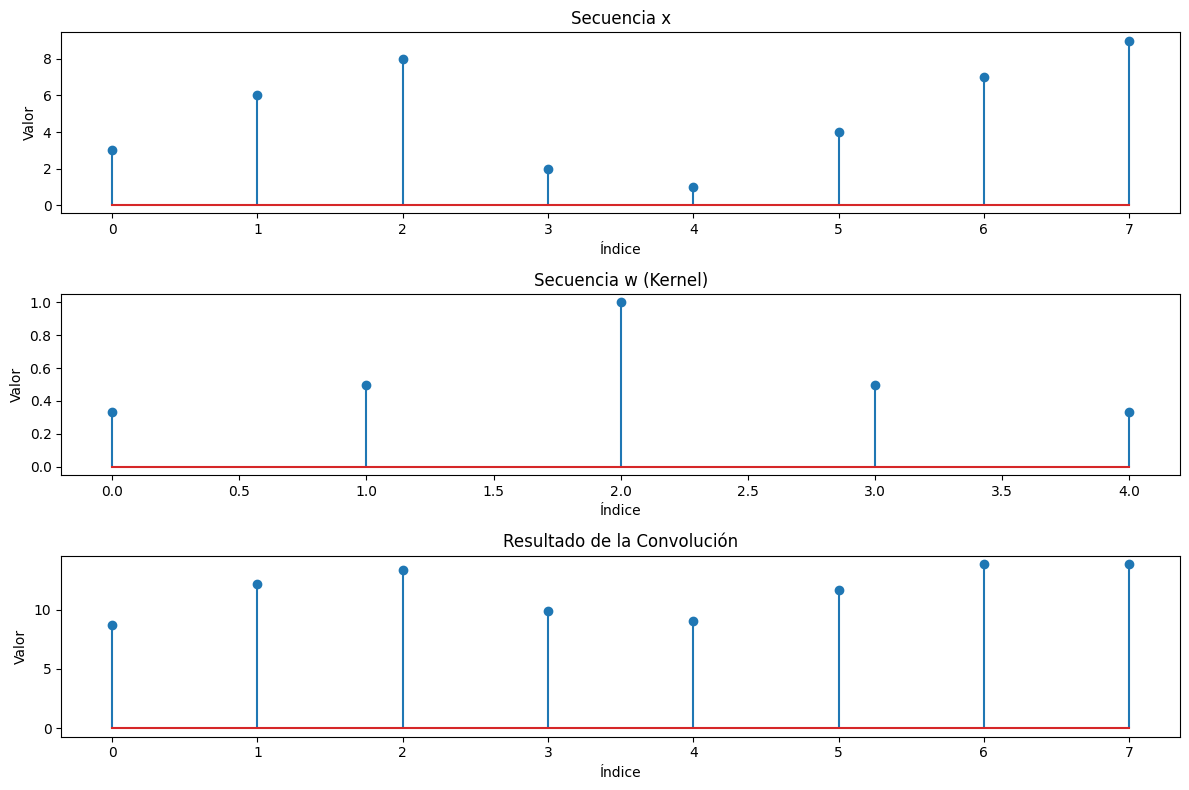

In [5]:
plt.figure(figsize=(12, 8))

# Graficar x
plt.subplot(3, 1, 1)
plt.stem(x, use_line_collection=True)
plt.title("Secuencia x")
plt.xlabel("Índice")
plt.ylabel("Valor")

# Graficar w
plt.subplot(3, 1, 2)
plt.stem(w, use_line_collection=True)
plt.title("Secuencia w (Kernel)")
plt.xlabel("Índice")
plt.ylabel("Valor")

# Graficar el resultado de la convolución
plt.subplot(3, 1, 3)
plt.stem(s, use_line_collection=True)
plt.title("Resultado de la Convolución")
plt.xlabel("Índice")
plt.ylabel("Valor")

plt.tight_layout()
plt.show()

# Convolucion 2D (Imagen)

$S(i,j) = (I*K) (i,j) = \sum_m \sum_n I(i-m,j-n) K(m,n)$

In [4]:
def conv2D(I, K):
    """
    Realizar una convolución 2D entre las matrices A y B.
    """
    # Dimensiones de las matrices
    i_rows, i_cols = I.shape
    k_rows, k_cols = K.shape

    # Matriz resultante con tamaño adecuado
    result = np.zeros((i_rows + k_rows - 1, i_cols + k_cols - 1))

    # Realizar la convolución
    for i in range(i_rows):
        for j in range(i_cols):
            result[i:i+k_rows, j:j+k_cols] += I[i, j] * K

    return result

Input

(100, 100)


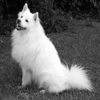

In [10]:
img = Image.open("dog.jpg").resize((100,100)).convert('L')
print(np.array(img).shape)
img

(3, 3)


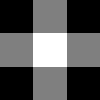

In [16]:
I = np.array(img)
K = np.array([[0,1, 0], 
            [1, 2, 1], 
            [0, 1, 0]])
K = K/np.max(K)
print(K.shape)
Image.fromarray((K*255/np.max(K)).astype(np.uint8)).resize((100,100), Image.NEAREST) # Visualizar kernel

Ejecutar convolucion

In [18]:
S = conv2D(I, K)

Visualizar

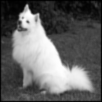

In [19]:
S_vis =  (255* S / S.max()).astype(np.uint8)
Image.fromarray(S_vis)

Eficiencia

In [16]:
def multiplicar_matrices(A, B):
    """
    Multiplicar dos matrices A y B usando bucles for.
    """
    # Obtener dimensiones de las matrices
    filas_A, columnas_A = A.shape
    filas_B, columnas_B = B.shape
    
    # Verificar si las matrices son multiplicables
    if columnas_A != filas_B:
        raise ValueError("Las columnas de A deben ser iguales a las filas de B para multiplicar.")
    
    # Crear una matriz resultante con ceros
    resultado = np.zeros((filas_A, columnas_B))
    
    # Realizar la multiplicación
    for i in range(filas_A):
        for j in range(columnas_B):
            suma = 0
            for k in range(columnas_A): # También es igual a filas_B
                suma += A[i, k] * B[k, j]
            resultado[i, j] = suma
            
    return resultado


In [17]:
import time

start_time = time.time()
I1 = np.array(img)
I2 = np.array(img)*0.5

w, h = I1.shape

out = multiplicar_matrices(I1, I2)

mat_time = time.time() - start_time
print("Tiempo de ejecución multiplicacion de matriz: %s segundos" % (time.time() - start_time))

start_time = time.time()
S = conv2D(I1, K)
conv_time = time.time() - start_time
print("Tiempo de ejecución convolucion: %s segundos" % (time.time() - start_time))

print(f"La convolucion es {mat_time/conv_time} veces mas rapida que la multiplicacion de matrices")

Tiempo de ejecución multiplicacion de matriz: 0.303997278213501 segundos
Tiempo de ejecución convolucion: 0.02700328826904297 segundos
La convolucion es 11.25778739184178 veces mas rapida que la multiplicacion de matrices


# Pooling

Obtener pools

In [20]:
def get_pools(img: np.array, pool_size: int, stride: int) -> np.array:
    # To store individual pools
    pools = []
    
    # Iterate over all row blocks (single block has `stride` rows)
    for i in np.arange(img.shape[0], step=stride):
        # Iterate over all column blocks (single block has `stride` columns)
        for j in np.arange(img.shape[0], step=stride):
            
            # Extract the current pool
            mat = img[i:i+pool_size, j:j+pool_size]
            
            # Make sure it's rectangular - has the shape identical to the pool size
            if mat.shape == (pool_size, pool_size):
                # Append to the list of pools
                pools.append(mat)
                
    # Return all pools as a Numpy array
    return np.array(pools)

Implementar max pooling

In [21]:
def max_pooling(pools: np.array) -> np.array:
    # Total number of pools
    num_pools = pools.shape[0]
    # Shape of the matrix after pooling - Square root of the number of pools
    # Cast it to int, as Numpy will return it as float
    # For example -> np.sqrt(16) = 4.0 -> int(4.0) = 4
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    # To store the max values
    pooled = []
    
    # Iterate over all pools
    for pool in pools:
        # Append the max value only
        pooled.append(np.max(pool))
        
    # Reshape to target shape
    return np.array(pooled).reshape(tgt_shape)

Array de ejemplo

In [1]:
conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
pools = get_pools(conv_output, 2, 2)
max_pooling(pools)

NameError: name 'np' is not defined

Imagen

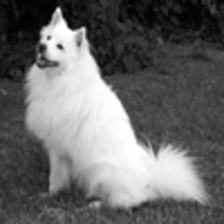

In [22]:
img = img.resize(size=(224, 224))
img

In [23]:
img_pools = get_pools(img=np.array(img), pool_size=2, stride=2)
img_pools

array([[[16, 19],
        [15, 17]],

       [[22, 25],
        [20, 22]],

       [[28, 27],
        [26, 27]],

       ...,

       [[69, 66],
        [69, 66]],

       [[62, 63],
        [61, 63]],

       [[65, 66],
        [65, 66]]], dtype=uint8)

In [24]:
output = max_pooling(pools=img_pools)
print(output.shape)

(112, 112)


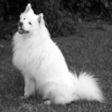

In [25]:
Image.fromarray(output.astype(np.uint8))

# Red convolucional
Fuente:  "Introduction to Deep Learning with PyTorch" Chanseok Kang

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU(inplace=True)
        
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Instantiate a fully connected layer
        self.fc = nn.Linear(49 * 10, 10)
        
    def forward(self, x):
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Prepare the image for the fully connected layer
        x = x.view(-1, 7 * 7 * 10)
        
        # Apply the fully connected layer and return the result
        return self.fc(x)

Entrenamiento

In [ ]:
import torchvision.transforms as transforms

# Transform the data to torch tensors and normalize it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

# Preparing the training and test set
trainset = torchvision.datasets.MNIST('mnist', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST('mnist', train=False, transform=transform, download=True)

# Prepare loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

Definir optimizador y criterio para loss

In [ ]:
import torch.optim as optim

net = Net()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

Entrenar

In [ ]:
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    
    # Compute the forward pass
    outputs = net(inputs)
    
    # Compute the loss function
    loss = criterion(outputs, labels)

    print(loss.item())
    # Compute the gradients
    loss.backward()
    
    # Update the weights
    optimizer.step()